### Laboratorium 6 - część projektowa

W tej części zajmiesz się wykorzystaniem punktów kluczowych do łączenia obrazów (_image stitching_). Celem zadania jest przetestowanie możliwości detekcji i parowania punktów kluczowych w celu łączenia obrazów. Istotne jest, by samodzielnie przejść całą ścieżkę: od detekcji punktów kluczowych i wyznaczenia ich desktryptorów, przez ich parowanie i znalezienie transformacji, po finalne połączenie obrazów. Rozwiązania oparte o gotowce w stylu black-box nie będą oceniane.

Wykonaj serię zdjęć dowolnej wybranej przez siebie **statycznej** sceny. Może to być niemal dowolny widok o dowolnej skali: panorama miasta, swojego pokoju, powierzchni biurka - ważne, by pozyskane obrazy umożliwiały (1) użycie algorytmu SIFT, oraz (2) wykonanie transformacji geometrycznej.

Wykonaj 4-5 zdjęć, spośród których pierwsze (nazwij je `base`) niech przedstawia \"główny\" widok sceny, a pozostałe (o nazwie `offset_{index}`) niech cechują się coraz większym przesunięciem kamery względem `base`. Proponowane różnice:
* nieznaczne przesunięcie (o ~połowę szerokości klatki),
* większe przesunięcie (o 3/4 szerokości lub więcej),
* przesunięcie z rotacją w osi kamery,
* (jeśli to możliwe) przybliżenie/oddalenie kamery.

Wykorzystaj algorytmy opracowane do realizacji zadania 3 (zwłaszcza 3b) w celu przekształcania obrazów `offset_x` do geometrii `base`. Upewnij się, że wymiary wynikowych obrazów są wystarczające do zmieszczenia obu składowych.

*Czy każdą parę `offset_i`-`base` udało się połączyć? Jeśli dla którejś pary metoda zawiodła, to dlaczego?*  
*Jaka była jakość dopasowania? Na jakiej podstawie ją określasz?*

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [28]:
from ipywidgets import interact, fixed, Layout, IntSlider, FloatSlider, Dropdown

In [38]:
root = 'lab6_zdjecia/zestaw_2'

base = cv2.imread(f'{root}/base.jpg')[..., ::-1]
offset_0 = cv2.imread(f'{root}/offset_0.jpg')[..., ::-1]
offset_1 = cv2.imread(f'{root}/offset_1.jpg')[..., ::-1]
offset_2 = cv2.imread(f'{root}/offset_2.jpg')[..., ::-1]
offset_3 = cv2.imread(f'{root}/offset_3.jpg')[..., ::-1]

In [39]:
def scale_img(img, scale_percent = 25):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_image = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized_image

base = scale_img(base)
offset_0 = scale_img(offset_0)
offset_1 = scale_img(offset_1)
offset_2 = scale_img(offset_2)
offset_3 = scale_img(offset_3)

In [7]:
def display_matcher(img1, img2, ct, et, n, d):
    
    sift = cv2.SIFT_create(nfeatures = n, contrastThreshold = ct, edgeThreshold = et)
    kp1, ds1 = sift.detectAndCompute(img1, mask = None)
    kp2, ds2 = sift.detectAndCompute(img2, mask = None)
    d_img1 = cv2.drawKeypoints(img1, kp1, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    d_img2 = cv2.drawKeypoints(img2, kp2, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(ds1, ds2, k = 2)
    good = []
    for m, n in matches:
        if m.distance < d * n.distance:
            good.append([m])
    matches_img = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    _, axs = plt.subplots(1, 1, figsize = (16, 10))
    axs.imshow(matches_img);
    axs.set_title('Distance constant = {}'.format(d))
    axs.axis('off')
    plt.show()
    
    
def interactive_matcher(img1, img2):
    slider_layout = Layout(width = '40%')
    ct_slider = FloatSlider(value = 0.08, min = 0, max = 1, step = 0.01, description = "contrastThreshold", layout = slider_layout)
    et_slider = FloatSlider(value = 4.2, min = 0, max = 50, step = 0.1, description = "edgeThreshold", layout = slider_layout)
    n_slider = IntSlider(value = 200, min = 0, max = 500, step = 1, description = "nfeatures", layout = slider_layout)
    d_slider = FloatSlider(value = 0.75, min = 0, max = 1, step = 0.01, description = "distance constant", layout = slider_layout)

    interact(display_matcher, img1 = fixed(img1), img2 = fixed(img2), ct = ct_slider, et = et_slider, n = n_slider, d = d_slider)

In [ ]:
interactive_matcher(base, offset_0)

interactive(children=(FloatSlider(value=0.08, description='contrastThreshold', layout=Layout(width='40%'), max…

In [9]:
from ipywidgets import interact, fixed, Layout, FloatSlider, Dropdown

def object_homography(img1, img2, ct = 0.04, et = 50, d = 0.75, method = cv2.RANSAC, ransac_thresh = 5.0):
    sift = cv2.SIFT_create(nfeatures = 0, contrastThreshold = ct, edgeThreshold = et)
    kp1, ds1 = sift.detectAndCompute(img1, None)
    kp2, ds2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = False)
    matches = bf.knnMatch(ds1, ds2, k = 2)

    good_matches = []
    for m, n in matches:
        if m.distance < d * n.distance:
            good_matches.append(m)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    if method == cv2.RANSAC or method == cv2.RHO:
        H, mask = cv2.findHomography(src_pts, dst_pts, method, ransac_thresh)
    else:
        H, mask = cv2.findHomography(src_pts, dst_pts, method)
        
    height, width, _ = img2.shape
    transformed_img = cv2.warpPerspective(img1, H, (width, height))
    
    _, axs = plt.subplots(1, 3, figsize = (15, 5))
    axs[0].imshow(img1);
    axs[0].set_title('Object image')
    axs[0].axis('off')
    axs[1].imshow(transformed_img);
    axs[1].set_title(f'Object transform')
    axs[1].axis('off')
    axs[2].imshow(img2);
    axs[2].set_title('Destination image')
    axs[2].axis('off')
    plt.show()
    
    
def interactive_homography(img1, img2):
    slider_layout = Layout(width = '40%')
    ct_slider = FloatSlider(value = 0.04, min = 0, max = 1, step = 0.01, description = "contrastThreshold", layout = slider_layout)
    et_slider = FloatSlider(value = 50, min = 0, max = 200, step = 0.1, description = "edgeThreshold", layout = slider_layout)
    d_slider = FloatSlider(value = 0.75, min = 0, max = 1, step = 0.01, description = "distance constant", layout = slider_layout)
    method_dropdown = Dropdown(
            options = [('Brak metody', 0), ('RANSAC', cv2.RANSAC), ('RHO', cv2.RHO)],
            value = cv2.RANSAC,
            description = 'Metoda:',
            layout = slider_layout
        )
    
    interact(object_homography, 
             img1 = fixed(img1), 
             img2 = fixed(img2), 
             ct = ct_slider, 
             et = et_slider, 
             d = d_slider, 
             method = method_dropdown)

In [37]:
interactive_homography(offset_0, base)

interactive(children=(FloatSlider(value=0.04, description='contrastThreshold', layout=Layout(width='40%'), max…

In [46]:
def stitch_images(img1, img2, ct = 0.04, et = 50, d = 0.75, method = cv2.RANSAC, ransac_thresh = 5.0):
    img1 = img1.copy()
    img2 = img2.copy()
    sift = cv2.SIFT_create(nfeatures = 0, contrastThreshold = ct, edgeThreshold = et)
    kp1, ds1 = sift.detectAndCompute(img1, None)
    kp2, ds2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = False)
    matches = bf.knnMatch(ds1, ds2, k = 2)

    good_matches = []
    for m, n in matches:
        if m.distance < d * n.distance:
            good_matches.append(m)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    if method == cv2.RANSAC or method == cv2.RHO:
        H, mask = cv2.findHomography(src_pts, dst_pts, method, ransac_thresh)
    else:
        H, mask = cv2.findHomography(src_pts, dst_pts, method)
        
    
    height1, width1, _ = img1.shape
    height2, width2, _ = img2.shape
    panorama_width = width1 + width2
    panorama_height = max(height1, height2)
    
    transformed_img = cv2.warpPerspective(img1, H, (panorama_width, panorama_height))
    transformed_img[0:height2, 0:width2] = img2
    return transformed_img

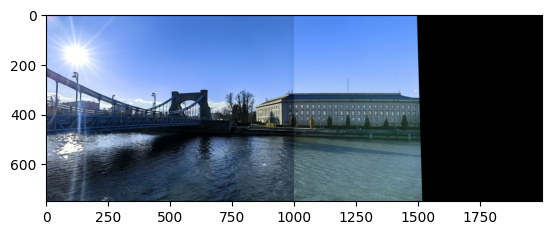

In [47]:
plt.imshow(stitch_images(offset_0, base))

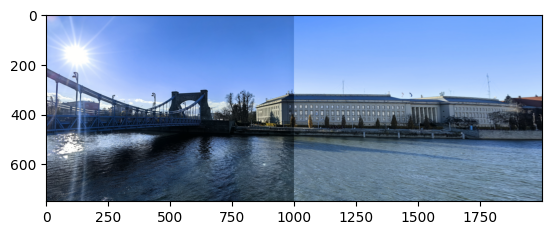

In [48]:
plt.imshow(stitch_images(offset_1, base))

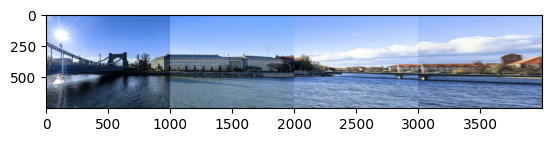

In [51]:
base0 = stitch_images(offset_1, base)
# base1 = stitch_images(offset_1, base0)
base2 = stitch_images(offset_2, base0)
base3 = stitch_images(offset_3, base2)
plt.imshow(base3)